<a href="https://colab.research.google.com/github/relmachtoub/projects/blob/main/Q2_CruiseBound.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal: Predict if client will subscribe to a term deposit

## Upload data & Libraries

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from joblib import dump
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import mean_absolute_error
import numpy as np
from sklearn.preprocessing import OrdinalEncoder

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
! ls  /content/gdrive/MyDrive/bank_data

bank.csv  bank-full.csv  bank-names.txt


In [4]:
bank_full = pd.read_csv('/content/gdrive/MyDrive/bank_data/bank-full.csv',sep=';')


In [5]:
display(bank_full.head())

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [6]:
bank_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


## Data Pre-Processing

In [7]:
bank_full['y'].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

### Check For Class Imbalance

In [8]:
## Let's update the target feature 'y' into binary classification, 1 being 'yes' & 0 being 'no'
bank_full = bank_full.replace({'y': {'no': 0, 
                                'yes': 1}})
bank_full['y'].value_counts()

0    39922
1     5289
Name: y, dtype: int64

### Correlation Matrix

In [9]:
bank_full.corr()

,age,balance,day,duration,campaign,pdays,previous,y
age,1.000000,0.097783,-0.009120,-0.004648,0.004760,-0.023758,0.001288,0.025155
balance,0.097783,1.000000,0.004503,0.021560,-0.014578,0.003435,0.016674,0.052838
day,-0.009120,0.004503,1.000000,-0.030206,0.162490,-0.093044,-0.051710,-0.028348
duration,-0.004648,0.021560,-0.030206,1.000000,-0.084570,-0.001565,0.001203,0.394521
campaign,0.004760,-0.014578,0.162490,-0.084570,1.000000,-0.088628,-0.032855,-0.073172
pdays,-0.023758,0.003435,-0.093044,-0.001565,-0.088628,1.000000,0.454820,0.103621
previous,0.001288,0.016674,-0.051710,0.001203,-0.032855,0.454820,1.000000,0.093236
y,0.025155,0.052838,-0.028348,0.394521,-0.073172,0.103621,0.093236,1.000000


### Define Features & Target

In [10]:
## create features and target 
target = bank_full['y']
features = bank_full.drop(['y'], axis=1)

In [11]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
dtypes: int64(7), object(9)
memory usage: 5.5+ MB


Text(0, 0.5, 'Frequency')

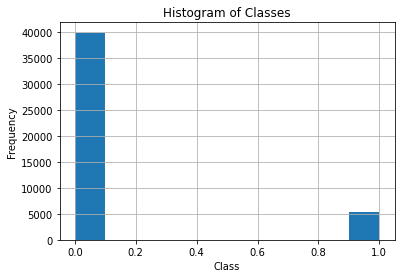

In [12]:
bank_full['y'].hist()
plt.title('Histogram of Classes')
plt.xlabel('Class')
plt.ylabel('Frequency')

In [13]:
bank_full.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y             int64
dtype: object

### Encode Categorical Features Using OHE

In [14]:
features = pd.get_dummies(features, drop_first=True)

In [15]:
features

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,5,261,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,44,29,5,151,1,-1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,33,2,5,76,1,-1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,47,1506,5,92,1,-1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,33,1,5,198,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,825,17,977,3,-1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
45207,71,1729,17,456,2,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
45208,72,5715,17,1127,5,184,3,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
45209,57,668,17,508,4,-1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


### Split & Normalize Data

In [16]:


features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=.2, random_state=12345)

scaler = StandardScaler()
scaler.fit(features_train)

features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)

## Evaluate Model Function

In [17]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(3)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Part 1: Build Classification Models

### Decision Tree Classifier

In [18]:
%%time
model = RandomForestClassifier(class_weight='balanced')

parameters = {'n_estimators': [10, 100], 'max_depth': [5, 25]}

from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(estimator=model, param_grid=parameters, scoring='roc_auc')
clf.fit(features_train, target_train)

CPU times: user 31.1 s, sys: 128 ms, total: 31.2 s
Wall time: 31.2 s


          train   test
Accuracy  0.999  0.908
F1        0.996  0.516
APS       1.000  0.628
ROC AUC   1.000  0.936


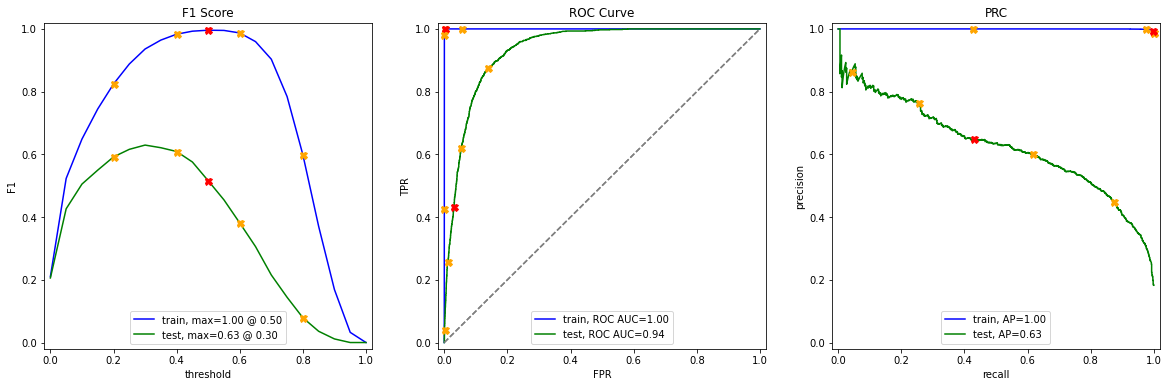

In [19]:
evaluate_model(clf, features_train, target_train, features_valid, target_valid)


In [20]:
predicted_train = clf.predict(features_train)
predicted_valid = clf.predict(features_valid)

In [21]:
f1_score_train = f1_score(target_train, predicted_train)
f1_score_valid = f1_score(target_valid, predicted_valid)

In [22]:
print(f1_score_train)
print(f1_score_valid)

0.9958953911105899
0.5159420289855072


### LGBM Classifier

In [23]:
%%time
from lightgbm import LGBMClassifier

lightgbm = LGBMClassifier(class_weight='balanced')

lightgbm.fit(features_train, target_train)

CPU times: user 2.22 s, sys: 48.7 ms, total: 2.27 s
Wall time: 1.25 s


          train   test
Accuracy  0.870  0.862
F1        0.631  0.599
APS       0.725  0.637
ROC AUC   0.958  0.940
CPU times: user 1.35 s, sys: 11.9 ms, total: 1.37 s
Wall time: 1.01 s


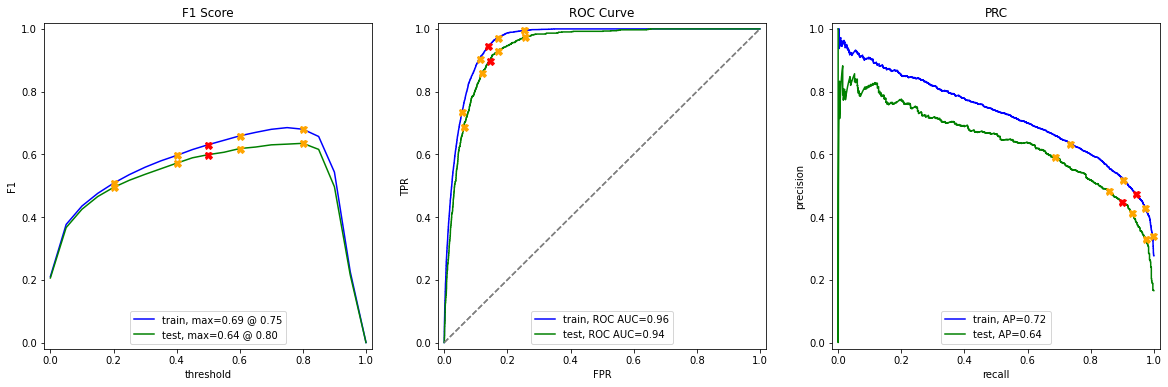

In [24]:
%%time
evaluate_model(lightgbm, features_train, target_train, features_valid, target_valid)


### Logistic Regression

          train   test
Accuracy  0.901  0.906
F1        0.448  0.470
APS       0.551  0.565
ROC AUC   0.906  0.916
CPU times: user 955 ms, sys: 406 ms, total: 1.36 s
Wall time: 904 ms


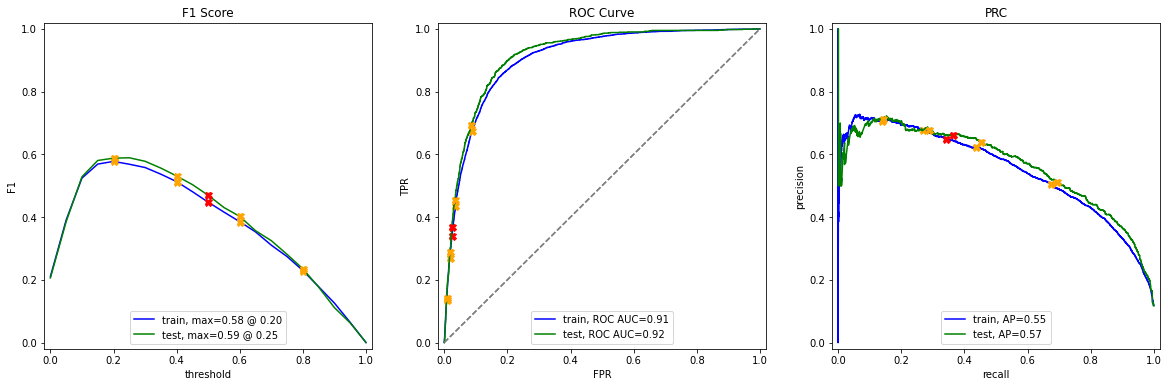

In [25]:
%%time

model = LogisticRegression()
model.fit(features_train, target_train)
evaluate_model(model, features_train, target_train, features_valid, target_valid)

#print(cross_val_score(model, features_train, target_train, scoring='accuracy'))



#### Sort Features in Order of Coefficient Weights

<BarContainer object of 42 artists>

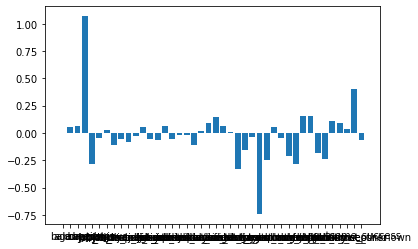

In [26]:
plt.bar(features.columns, model.coef_[0])


In [27]:
linear_regression_weights = pd.DataFrame({'column_name':features.columns,'weights': model.coef_[0]})
linear_regression_weights.sort_values('weights', ascending=False, inplace=True)
linear_regression_weights.reset_index(drop=True, inplace=True)
linear_regression_weights.head()

,column_name,weights
0,duration,1.068610
1,poutcome_success,0.403280
2,month_mar,0.159211
3,month_jun,0.153437
4,education_tertiary,0.145272


### Summary:
- We encoded all categorical features using O.H.E.
- There is a large class imbalance, however the models handled this internally. If needed, we can manually upsample the targets with 1 to restore balance.
- We normalized all the data.
- Cross validation was used for fitting the models.
- The models can easily handle up to 100 features on the local processor.
- We tuned the hyperparameters of Decision Tree Classifier using GridsearchCV. Our accuracy = .91 & ROC AUC = .936 on the test set. The only downside to this model is that it takes a longer time to fit.
- Logistic Regression has an accuracy = .906 & ROC AUC = .916 on the test set. This model is fast and lightweight, which is why it is my model of choice. It's easy to use and often produces great results.
- Scores measured: Accuracy, F1, APS, ROC AUC. 
- Accuracy is good for measuring all correctly identified cases, however has drawbacks when there is class imbalance.
- F1 is better suited for this campaign because it deals with class imbalance better. F1 is also used when false negatives and false positives are critical. In this scenario a false positive can lead to angry customers which we can see from the negative weight calculated for that feature.
- LGBM Classifier has the best F1 score at .599 & also runs relatively quick compared to decision tree classifier.


## Part 2: What actionable insights would you share with marketing team?

### Pick a Model
- First off, let's pick a model from the 3 above to run our data analytics on. My preferred choice of model is logistic regression because it's lightweight, runs fast, we can extract the weights easy, & it gives us a good accuracy score at over 90%.

### Features with Highest and Lowest Weights

- The above charts shows us each feature's weight calculated from our linear regression model.
- Positive weights represent positive correlation & negative weights represent negative correlation to our target; whether a client will subscribe to a term deposit.

In [28]:
display('Columns With Highest 5 Weights:', linear_regression_weights.head(5))
print()
display('Columns With Lowest 5 Weights:', linear_regression_weights.tail(5))

'Columns With Highest 5 Weights:'

,column_name,weights
0,duration,1.068610
1,poutcome_success,0.403280
2,month_mar,0.159211
3,month_jun,0.153437
4,education_tertiary,0.145272


'Columns With Lowest 5 Weights:'

,column_name,weights
37,month_aug,-0.247146
38,campaign,-0.279712
39,month_jul,-0.288027
40,housing_yes,-0.328917
41,contact_unknown,-0.741727


### Top 5 features with positive correlation and explanations:
- Duration: higher duration of last calls indicates a higher customer interest. This is by far the most important metric because it's weight dwarfs the rest of the features. I would advise the marketing team to invest a lot of time with customers who had long duration calls during the last campaign. 
- P Outcome: If the last campaign was succesful with the customer than they are more likely to be successful for the current campaign.
- March & June: Have are the best months to campaign.
- Customers with tertiary education are more likely to contribute to a term depsosit than people with lower education.


### Top 5 features with negative correlation and  explanations:
- Contact Unknown: missing contact information is a huge issue as shown by our most negative feature weight. I would advise the marketing team to emphasize getting contact information.
- Housing loans: if a customer has a housing loan it negatively contributes to the campaign.
- August & July: are the worst months to run the campaign.
- Campaign: This metric represent the number of contacts for the campaign. The higher the number the more negative it impacts our target. I advise the marketing team to try and sell the customer with as few contacts as possible.


### Additional Data Collection
- I would like to collect additional features on the customers so we can improve our model. Features I suggest collecting would be: family, gender, geography, credit score, & number of products. 
- I chose these features to start with because they are usually accessible and are common for bank customer data sets. 
- If we need to squeeze more out of our model scores we can move into feature extraction. We can discover more about the customer by classifying them using clustering methods

-  A cost effective starting point would be to focus on collecting relevant/available customer features from the bank's database or external databases.
- Our linear regression model uses gradient descent which is easy to use and simple to understand, its drawback is that it can take up too much memory. If our dataset becomes very large we can look to use models that use SGD which uses less memory but has greater variance.
